In [1]:
# Cellule 0 — installer MNE dans ce kernel
%pip install -U pip setuptools wheel
%pip install "mne>=1.6,<1.8"


  Using cached pip-25.2-py3-none-any.whl.metadata (4.7 kB)
  Using cached wheel-0.45.1-py3-none-any.whl.metadata (2.3 kB)
Using cached pip-25.2-py3-none-any.whl (1.8 MB)
Using cached wheel-0.45.1-py3-none-any.whl (72 kB)
  Attempting uninstall: pip
    Found existing installation: pip 24.3.1
    Uninstalling pip-24.3.1:
      Successfully uninstalled pip-24.3.1
Note: you may need to restart the kernel to use updated packages.
  Using cached mne-1.7.1-py3-none-any.whl.metadata (13 kB)
Using cached mne-1.7.1-py3-none-any.whl (7.4 MB)
  Attempting uninstall: mne
    Found existing installation: mne 1.10.2
    Uninstalling mne-1.10.2:
      Successfully uninstalled mne-1.10.2
Note: you may need to restart the kernel to use updated packages.


In [3]:
import os, numpy as np, pandas as pd, matplotlib.pyplot as plt
import mne



In [4]:
import os, numpy as np, pandas as pd, matplotlib.pyplot as plt
import mne

def read_raw_safe(path):
    try:
        return mne.io.read_raw_fif(path, preload=True, verbose="ERROR", allow_maxshield=True)
    except Exception:
        return mne.io.read_raw_fif(path, preload=True, verbose="ERROR", allow_maxshield=False)

def bit_decompose_uint16(arr_uint16, n_bits=16):
    return {b: ((arr_uint16 >> b) & 1).astype(np.uint8) for b in range(n_bits)}

def rising_edge_indices(binary_arr):
    x = np.asarray(binary_arr, dtype=np.uint8)
    dx = np.diff(x, prepend=x[0])
    return np.where(dx == 1)[0]

def extract_sti_events(raw):
    sfreq = float(raw.info["sfreq"])
    stim_picks = mne.pick_types(raw.info, stim=True, misc=False, meg=False, eeg=False, eog=False, ecg=False)
    events = {}
    if len(stim_picks) >= 1:
        stim_data = raw.get_data(picks=stim_picks)
        if stim_data.shape[0] == 1:
            sti_vals = stim_data[0, :].astype(np.int64)
            for b, barr in bit_decompose_uint16(sti_vals, 16).items():
                idx = rising_edge_indices(barr)
                if len(idx): events[f"STI{b}"] = idx / sfreq
        else:
            for ch in stim_picks:
                name = raw.ch_names[ch]
                x = (raw.get_data(picks=[ch])[0] > 0).astype(np.uint8)
                idx = rising_edge_indices(x)
                if len(idx): events[name] = idx / sfreq
    return events  # dict: name -> times(s)


In [ ]:
FILE_SIMU = "/home/neurostim/mirian/MEG_USBio/fif/4_simultaneous.fif"
raw = read_raw_safe(FILE_SIMU)
sti_ev = extract_sti_events(raw)
pd.DataFrame(
    [{"channel":k, "n_events":len(v)} for k,v in sti_ev.items()]
).sort_values("channel")


,channel,n_events
0,STI001,7
1,STI002,7
2,STI003,7
3,STI004,7
4,STI101,7


In [ ]:
FILE_SIMU = "/home/neurostim/mirian/MEG_USBio/fif/4_simultaneous.fif"
raw = read_raw_safe(FILE_SIMU)
sti_ev = extract_sti_events(raw)

sti_four = ["STI001","STI002","STI003","STI004"] 
times = {ch: sti_ev.get(ch, np.array([])) for ch in sti_four}

# tableau "par index d'événement"
max_n = max(len(v) for v in times.values())
df_times = pd.DataFrame({
    ch+"_s": np.pad(times[ch], (0, max_n - len(times[ch])), constant_values=np.nan)
    for ch in sti_four
})
# une version en millisecondes (pratique à l'œil)
df_times_ms = df_times * 1e3
df_times_ms



,STI001_s,STI002_s,STI003_s,STI004_s
0,710.0,710.0,710.0,710.0
1,5723.0,5723.0,5723.0,5723.0
2,10735.0,10735.0,10735.0,10735.0
3,15748.0,15748.0,15748.0,15748.0
4,20761.0,20761.0,20761.0,20761.0
5,25774.0,25774.0,25774.0,25774.0
6,30786.0,30786.0,30786.0,30786.0


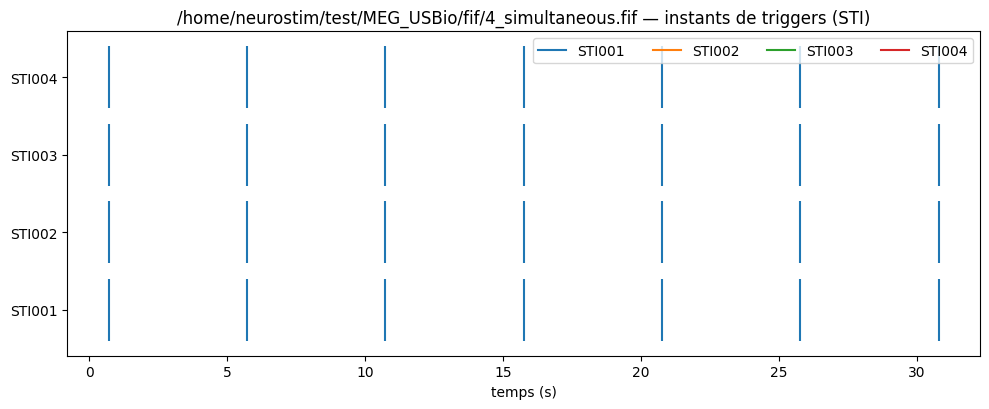

In [7]:
plt.figure(figsize=(10, 3 + 0.3*len(sti_four)))
for i, ch in enumerate(sti_four):
    t = times[ch]
    y = np.full_like(t, i, dtype=float)
    plt.vlines(t, i-0.4, i+0.4)   # un trait par événement au temps t
    plt.plot([], [], label=ch)    # juste pour la légende
plt.yticks(range(len(sti_four)), sti_four)
plt.xlabel("temps (s)"); plt.title(f"{FILE_SIMU} — instants de triggers (STI)")
plt.legend(loc="upper right", ncol=len(sti_four))
plt.tight_layout(); plt.show()


In [ ]:
FILE_BTN = "/home/neurostim/mirian/MEG_USBio/fif/meg_timing_recep_exec.fif"
raw2 = read_raw_safe(FILE_BTN)
sti_ev2 = extract_sti_events(raw2)

# Aide: lister STI dispo et leurs comptages
pd.DataFrame(
    [{"channel":k, "n_events":len(v)} for k,v in sti_ev2.items()]
).sort_values("channel")


,channel,n_events
0,STI001,7
1,STI009,7
2,STI101,7


In [ ]:
FILE_BTN = "/home/neurostim/mirian/MEG_USBio/fif/meg_timing_recep_exec.fif"
raw = read_raw_safe(FILE_BTN)
sti_ev = extract_sti_events(raw)

sti_two = ["STI001","STI009"] 
times = {ch: sti_ev.get(ch, np.array([])) for ch in sti_two}

# tableau "par index d'événement"
max_n = max(len(v) for v in times.values())
df_times = pd.DataFrame({
    ch+"_s": np.pad(times[ch], (0, max_n - len(times[ch])), constant_values=np.nan)
    for ch in sti_two
})
# une version en millisecondes (pratique à l'œil)
df_times_ms = df_times * 1e3
df_times_ms["decalage_ms"] = df_times_ms["STI001_s"] - df_times_ms["STI009_s"]
df_times_ms





,STI001_s,STI009_s,decalage_ms
0,10437.0,10437.0,0.0
1,13823.0,13823.0,0.0
2,16720.0,16720.0,0.0
3,17439.0,17438.0,1.0
4,20320.0,20320.0,0.0
5,23795.0,23795.0,0.0
6,27179.0,27179.0,0.0
